# Objective
- Develop a binary classification model for Beta Bank that would analyze data on clients’ past behavior and termination of contracts with the bank and predict whether a customer will leave the bank soon.  The target variable is exited.
- Although we are interested  in understanding why customers are leaving the bank, it  is equally  important to understand who is staying.  That is because we  want to retain them and attract more customers like them. Both exited and  retained are different sides of the same coin.  For this classification project then, both retained  and exited  customer behavior is important and we are interested in true positives for both classes equally.  Technically, we are interested in high  precision for both classes, i.e., of all the positive predictions our models make, how many of them are truly positive?  Although both precision and recall are important, the most important for this project is high precision for exited and high precision for retained.
- This means it is important for us to SMOTE the  binary target variable in order to get a more sensitive classifier.

In [1]:
import pandas as pd
import matplotlib
import numpy as np
import seaborn as sns
import re
from sklearn.utils import shuffle

from sklearn.preprocessing import StandardScaler as ss
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
#%pip install imblearn
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn import decomposition
from sklearn.metrics import plot_roc_curve
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC
import statsmodels.api as sm
from statsmodels.formula.api import ols
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN


import pickle
import joblib



from sklearn.dummy import DummyClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
%matplotlib inline
%pip install imblearn
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

pd.set_option('display.max_rows', None)

print("Setup Complete")

/Users/Rhea/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/Rhea/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


Note: you may need to restart the kernel to use updated packages.
Setup Complete


In [2]:
try:
    df = pd.read_csv('Churn.csv')
    
except:
    df = pd.read_csv('/datasets/Churn.csv')

# Preprocess the data

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


## Change the column names

In [5]:
columns = []
for name in df.columns.values:
    name = re.sub('([A-Z])', r' \1', name).lower().replace(' ', '_')[1:]
    columns.append(name)

In [6]:
df.columns = columns

## Fill NAs and  change type

In [7]:
df.tenure.isnull().sum()

909

In [8]:
df['tenure'] = df.groupby('num_of_products')['tenure'].apply(lambda x: x.fillna(x.mean()))

In [9]:
df['tenure'] = df['tenure'].astype(int)

## Check for duplicates

In [10]:
df.duplicated().sum()

0

## Drop useless columns

In [11]:
df = df.drop(['customer_id','row_number', 'surname'], axis=1)

# Understand the data

In [12]:
df.describe()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.948000,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.768549,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


## The features

### The continuous, float features

In [13]:
def show_hist_loat_chart(dataframe: pd.core.frame.DataFrame, column_name: float):
    hist_data = dataframe[column_name]

    hist_data.plot(
        kind='hist', density=True, figsize=(15, 5), rot=90, alpha=.5, fontsize=8
    )
    
    beautify_column_name = column_name[0].upper() + column_name[1:].replace('_', ' ')
    
    plt.title(f'  Distribution of {beautify_column_name}', fontsize=18)
    plt.ylabel('Share', fontsize=10)
    plt.xlabel(beautify_column_name, fontsize=10)

    plt.show()

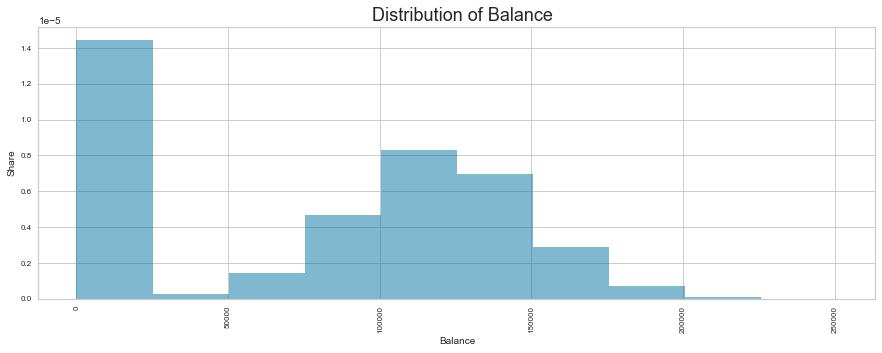

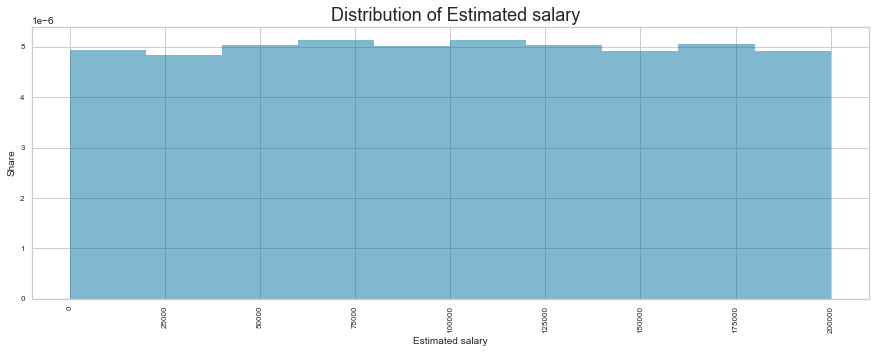

In [14]:
for column in df.columns:
    if df[column].dtype == 'float':
        show_hist_loat_chart(df, column)

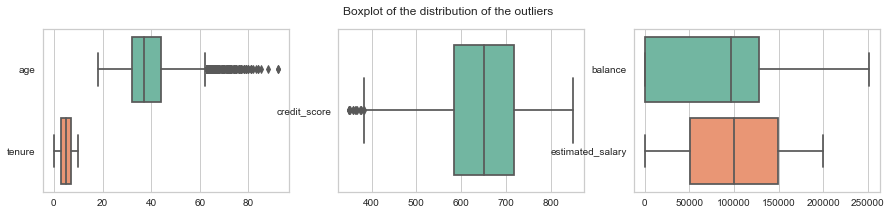

In [15]:
fig, axs = plt.subplots(1,3, figsize=(15,3))
sns.boxplot(data = df.loc[:, [ "age",'tenure']], orient="h", palette="Set2", ax = axs[0])
#sns.swarmplot(data = df.loc[:, ['tenure',  'has_cr_card', 'is_active_member']], orient="h", color=".25", size=1, ax = axs[0])
sns.boxplot(data = df.loc[:,[ 'credit_score']], orient="h", palette="Set2", ax = axs[1])
sns.boxplot(data = df.loc[:,['balance','estimated_salary']], orient="h", palette="Set2", ax = axs[2])
#sns.swarmplot(data = df['balance','estimated_salary'], orient="h", color=".25", size=1, ax = axs[2])
plt.suptitle("Boxplot of the distribution of the outliers")

plt.show()

### Conclusion:
The continuous data has outliers (age)  and is skewed (balance).  But this data  abnormality is not  huge  and hence does not require a robust scaler.

###  Relationship between  variables and the  target variable

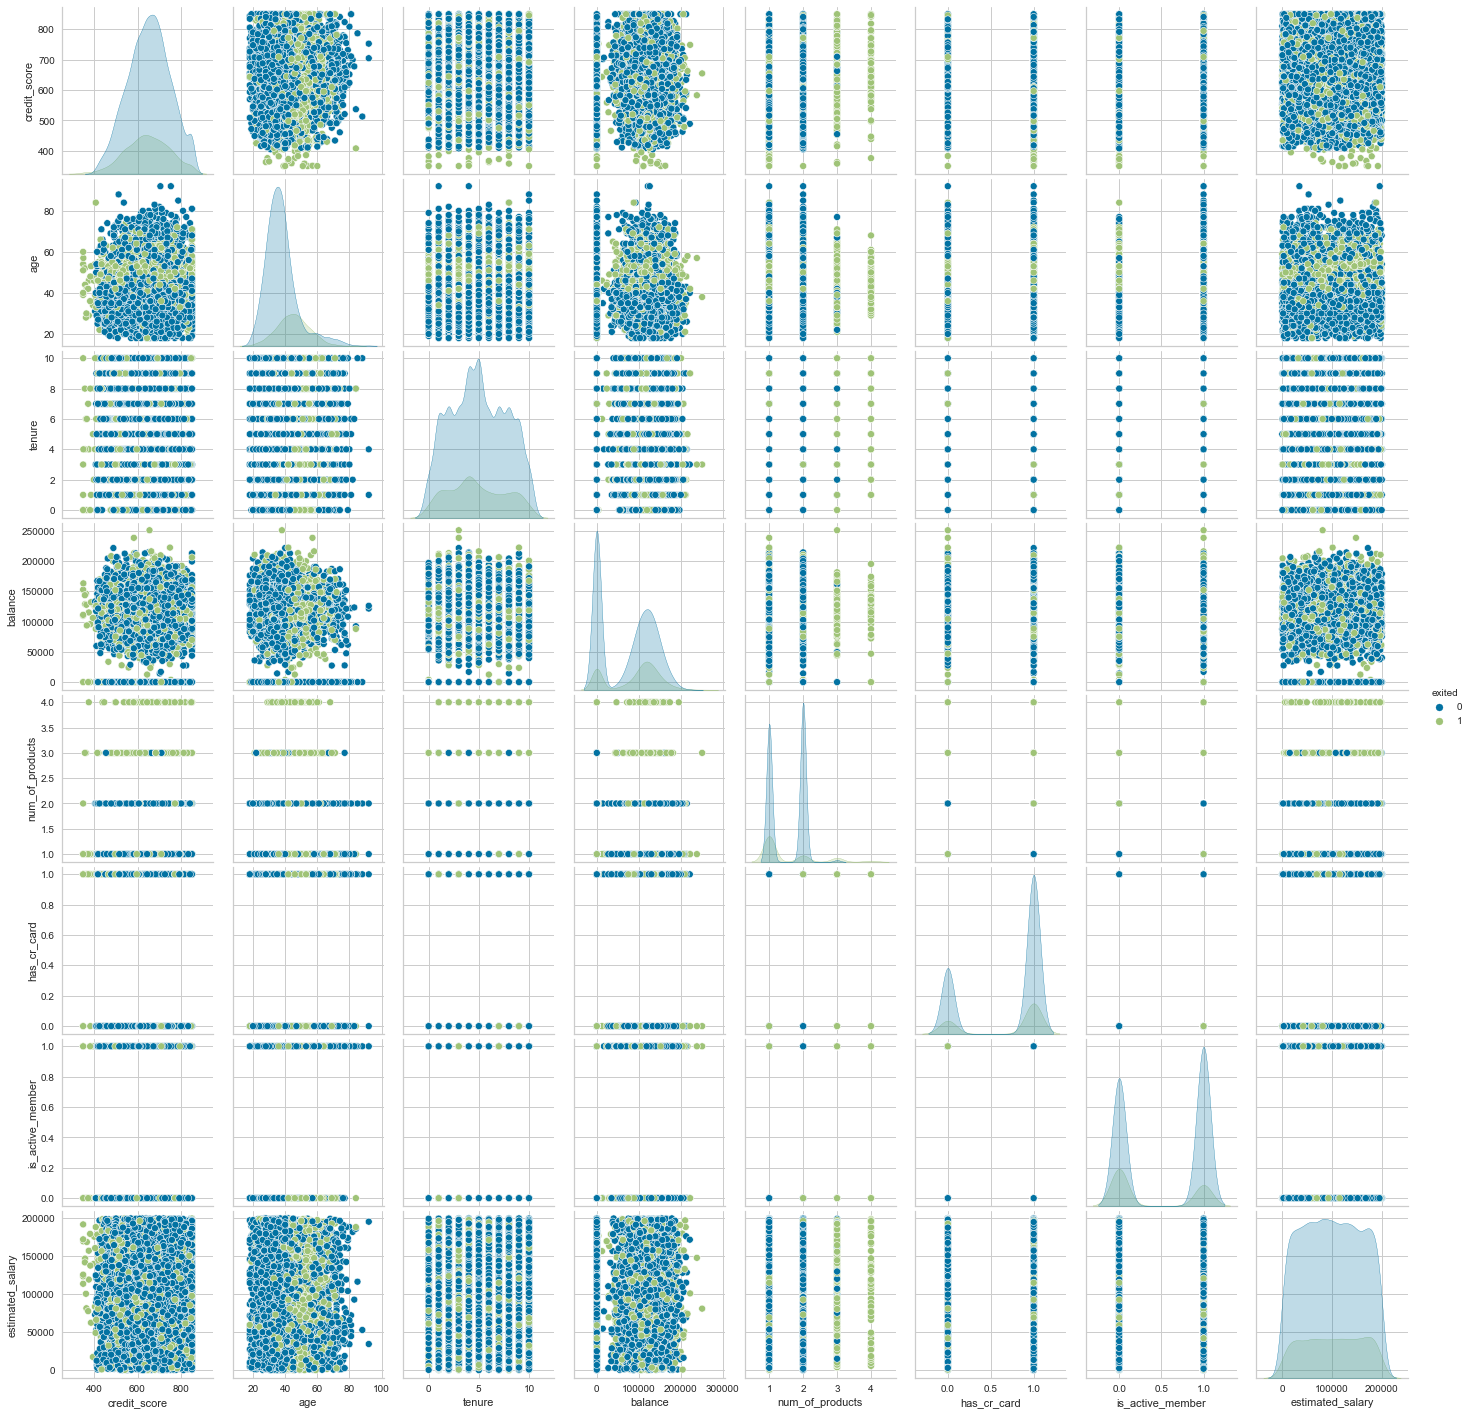

In [16]:
sns.pairplot(df, hue='exited');

#### Conclusion:
People with lower credit score exited, they are younger  in age, have been  customers  of the bank for a  shorter tenure. The balance variable is bimodal for both exited and current clients.  Only clients with lower salary  have exited. Balance is left skewed with the median balance higher than the mean.  Age is a tad right skewed.

### The categorical and integer features

In [17]:
def show_bar_chart(dataframe: pd.core.frame.DataFrame, column_name: (object,int) ):
    bar_data = dataframe[column_name].value_counts(normalize=True).head(10)

    bar_data.plot(
        kind='bar', figsize=(15, 5), rot=90, alpha=.5, fontsize=12
    )
    
    beautify_column_name = column_name[0].upper() + column_name[1:].replace('_', ' ')
    
    plt.title(f' Share of {beautify_column_name}', fontsize=18)
    plt.ylabel('Share', fontsize=14)
    plt.xlabel(beautify_column_name, fontsize=14)

    for i, (x, y) in enumerate(bar_data.to_dict().items()):
        plt.text(i-.15, y, s=str(round(y, 2)), fontsize=12)

    plt.show()

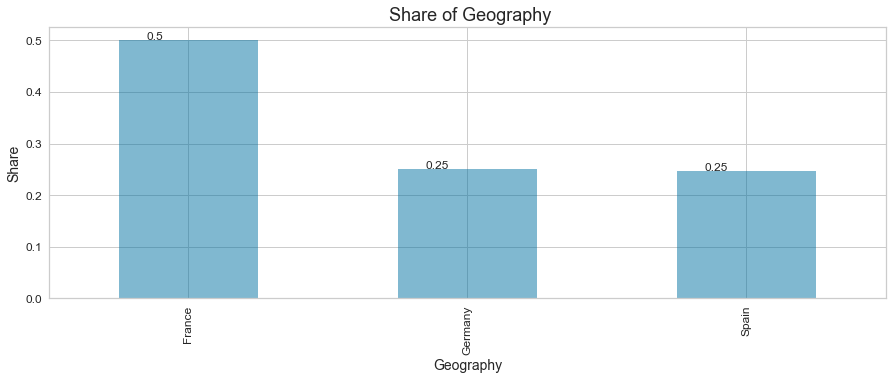

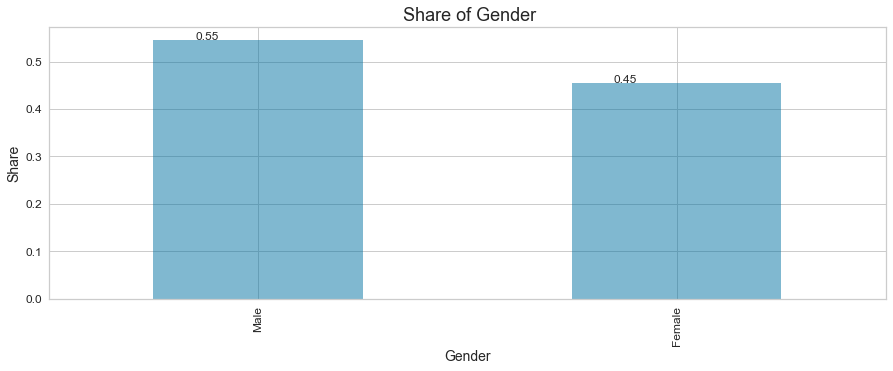

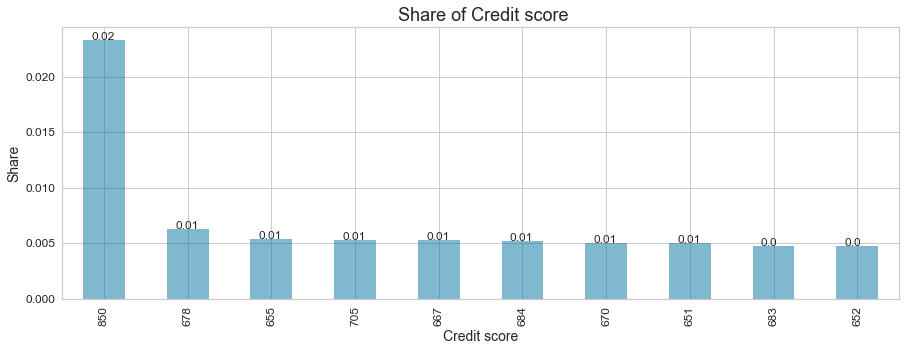

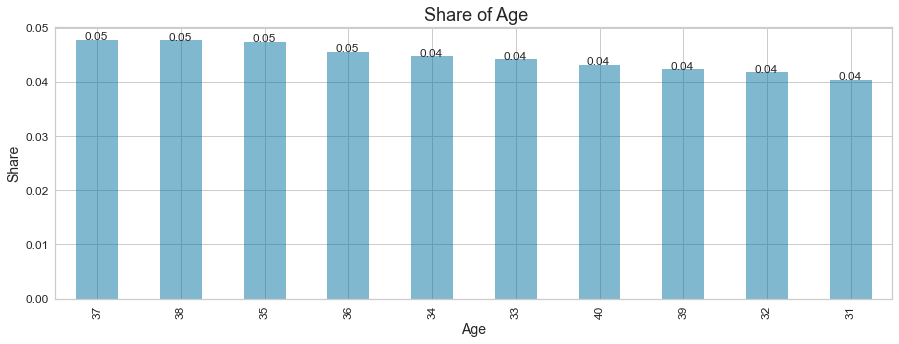

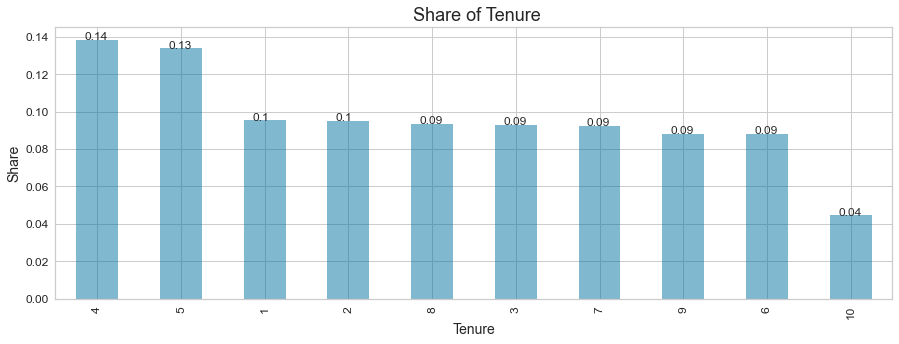

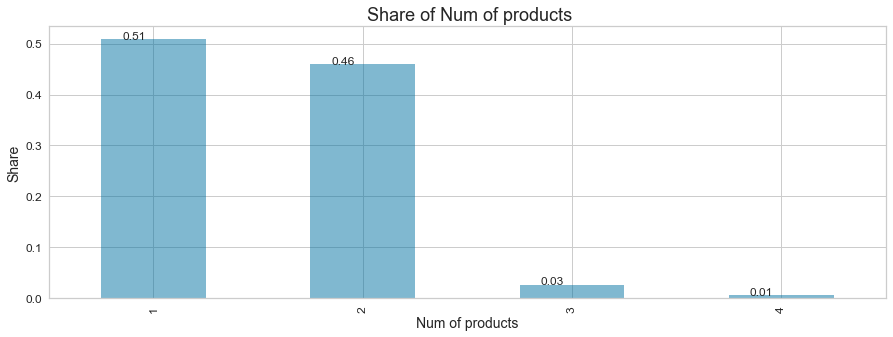

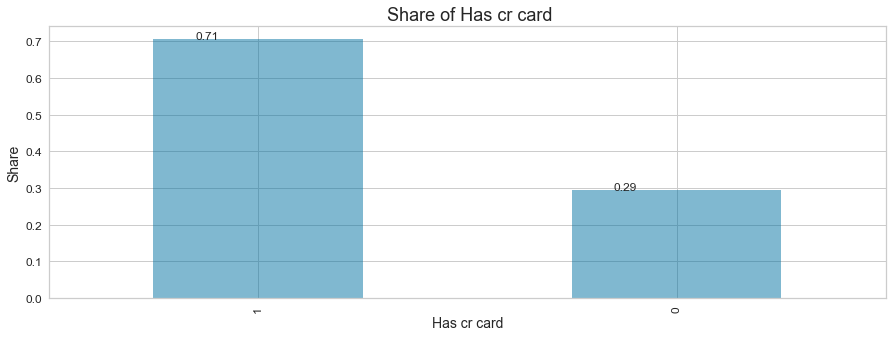

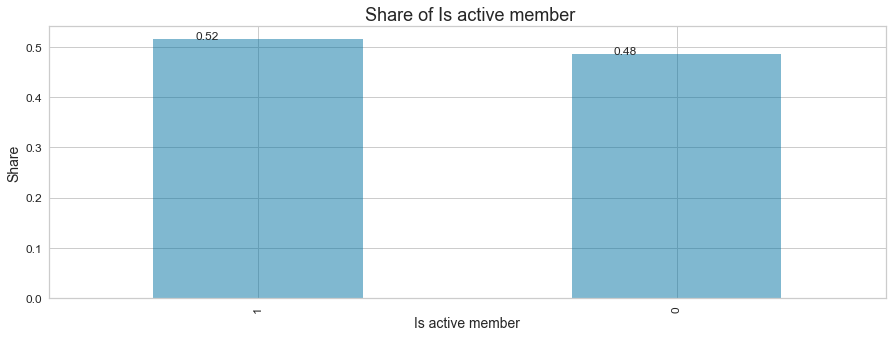

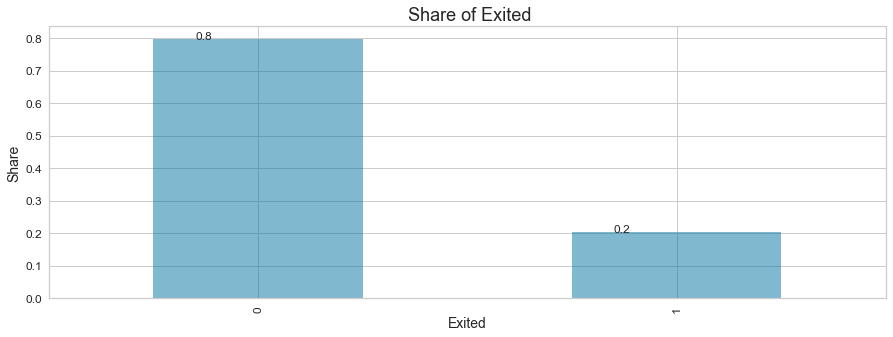

In [18]:
for column in df.columns:
    if df[column].dtype == 'object':
        show_bar_chart(df, column)
for column in df.columns:
    if df[column].dtype == 'int':
        show_bar_chart(df, column)

### Conclusion:
There are outliers on the upper end of age, lower end of credit score and upper end of number of products.  Otherwise, the are no outliers.  As we have seen above, our target is imbalanced  with only  20\% exited customers.

###  Relationship of categorical and integer features with the target variable

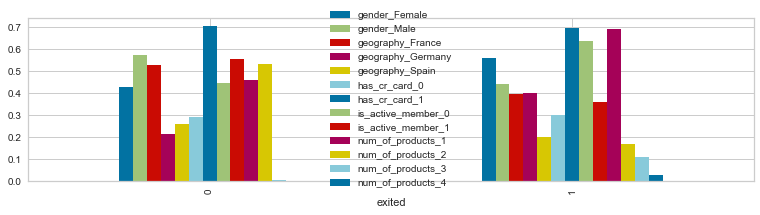

In [19]:
df1=pd.get_dummies(df, columns=['gender','geography','has_cr_card', 'is_active_member', 'num_of_products'])
df1 = df1.drop(['credit_score', 'age', 'tenure', 'balance', 'estimated_salary'], axis =1)
(df1.groupby('exited').mean()).plot(kind='bar', figsize=(13, 3))
plt.legend(loc='center');

In [20]:
df.groupby("gender")['exited'].value_counts(normalize = True)

gender  exited
Female  0         0.749285
        1         0.250715
Male    0         0.835441
        1         0.164559
Name: exited, dtype: float64

25\% of women exited compared to 16.5\% of man.

In [21]:
df.groupby("geography")['exited'].value_counts(normalize = True)

geography  exited
France     0         0.838452
           1         0.161548
Germany    0         0.675568
           1         0.324432
Spain      0         0.833266
           1         0.166734
Name: exited, dtype: float64

16\% of French exited, 35\% of Germany and 16\% of Spain.

In [22]:
df.groupby("has_cr_card")['exited'].value_counts(normalize = True)

has_cr_card  exited
0            0         0.791851
             1         0.208149
1            0         0.798157
             1         0.201843
Name: exited, dtype: float64

similar

In [23]:
df.groupby("is_active_member")['exited'].value_counts(normalize = True)

is_active_member  exited
0                 0         0.731491
                  1         0.268509
1                 0         0.857309
                  1         0.142691
Name: exited, dtype: float64

More inactive than active members exited

In [24]:
df.groupby("num_of_products")['exited'].value_counts(normalize = True)

num_of_products  exited
1                0         0.722856
                 1         0.277144
2                0         0.924183
                 1         0.075817
3                1         0.827068
                 0         0.172932
4                1         1.000000
Name: exited, dtype: float64

#### Conclusion:
Around 28\% of those with only  1 products exited; the number  of those who exited with 2 product is negligible.  A stunning 82\% of those customers with 3 products exited and all those customers with 4 products exited.  There is evidence  of exodus among the customers with more than 2 products.

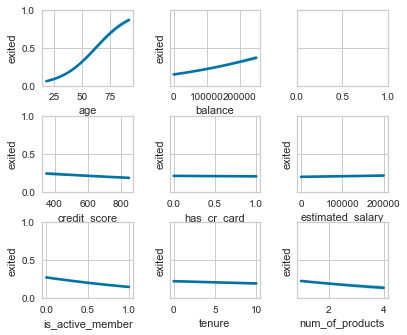

In [25]:
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6),(ax7, ax8, ax9)) = plt.subplots(ncols=3, nrows = 3, sharey = True)
sns.regplot(x = "age",
            y = "exited", 
             ci=95, logistic = True,
            scatter_kws={"s": 1}, ax = ax1,
            data = df)
ax1.set(ylim=(0, 1))


sns.regplot(x = "balance",
            y = "exited", 
             ci=95, logistic = True,
            scatter_kws={"s": 1}, ax=ax2,
            data = df)
ax2.set(ylim=(0, 1))

sns.regplot(x = "tenure",
            y = "exited", 
             ci=95, logistic = True,
            scatter_kws={"s": 1}, ax = ax8,
            data = df)
ax3.set(ylim=(0, 1))


sns.regplot(x = "credit_score",
            y = "exited", 
             ci=95, logistic = True,
            scatter_kws={"s": 1}, ax=ax4,
            data = df)
ax4.set(ylim=(0, 1))
sns.regplot(x = "has_cr_card",
            y = "exited", 
             ci=95, logistic = True,
            scatter_kws={"s": 1}, ax = ax5,
            data = df)
ax5.set(ylim=(0, 1))


sns.regplot(x = 'estimated_salary',
            y = "exited", 
             ci=95, logistic = True,
            scatter_kws={"s": 1}, ax=ax6,
            data = df)
ax6.set(ylim=(0, 1))

sns.regplot(x = "is_active_member",
            y = "exited", 
             ci=95, logistic = True,
            scatter_kws={"s": 1}, ax=ax7,
            data = df)
ax7.set(ylim=(0, 1))

#sns.regplot(x = #'estimated_salary',
 #           y = "exited", 
 #            ci=95, logistic = True,
 #           scatter_kws={"s": 1}, ax=ax3,
 #           data = df)
#ax8.set(ylim=(0, 1))

sns.regplot(x = "num_of_products",
            y = "exited", 
             ci=95, logistic = True,
            scatter_kws={"s": 1}, ax=ax9,
            data = df)
ax9.set(ylim=(0, 1))

plt.subplots_adjust(left=0.1,
                    bottom=1, 
                    right=0.9, 
                    top=2, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show();
 

### Conclusion:
Tenure, estimated salary and has credit card seem to not have an   effect  on the target.  But we need to probe some more. 

## Check the data

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  int64  
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


## Dummying the data

In [27]:
predictestimated_salary','tenure' , 'balance'], axis=1)

In [28]:
df_OHE = pd.get_dummies(df, drop_first=True)
df_OHE.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


In [29]:
df_inc_OHE = pd.get_dummies(df_inc, drop_first=True)
df_inc_OHE.head()

,credit_score,age,num_of_products,is_active_member,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,1,1,1,0,0,0
1,608,41,1,1,0,0,1,0
2,502,42,3,0,1,0,0,0
3,699,39,2,0,0,0,0,0
4,850,43,1,1,0,0,1,0


## Create the feature and target

In [30]:
X = df_OHE.drop('exited', axis=1)
y = df_OHE['exited']
X_inc = df_inc_OHE.drop('exited', axis=1)
y_inc = df_inc_OHE['exited']

###  Accounting for the option without the card feature

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = True, stratify = y, random_state=12345)
X_train_inc, X_test_inc, y_train_inc, y_test_inc = train_test_split(X_inc, y_inc, test_size=0.3, shuffle = True, stratify = y, random_state=12345)


print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_train_cr dataset: ", X_train_inc.shape)
print("Number transactions y_train_cr dataset: ", y_train_inc.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)
print("Number transactions X_test_cr dataset: ", X_test_inc.shape)
print("Number transactions y_test_cr dataset: ", y_test_inc.shape)

Number transactions X_train dataset:  (7000, 11)
Number transactions y_train dataset:  (7000,)
Number transactions X_train_cr dataset:  (7000, 7)
Number transactions y_train_cr dataset:  (7000,)
Number transactions X_test dataset:  (3000, 11)
Number transactions y_test dataset:  (3000,)
Number transactions X_test_cr dataset:  (3000, 7)
Number transactions y_test_cr dataset:  (3000,)


### Get coefficients for more information about feature explanatory value

In [32]:
logit_model=sm.MNLogit(y_train,sm.add_constant(X_train))
logit_model
result=logit_model.fit()
stats1=result.summary()
stats2=result.summary2()
print(stats1)
print(stats2)

Optimization terminated successfully.
         Current function value: 0.429243
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                 exited   No. Observations:                 7000
Model:                        MNLogit   Df Residuals:                     6988
Method:                           MLE   Df Model:                           11
Date:                Tue, 10 May 2022   Pseudo R-squ.:                  0.1509
Time:                        22:11:51   Log-Likelihood:                -3004.7
converged:                       True   LL-Null:                       -3538.6
Covariance Type:            nonrobust   LLR p-value:                5.091e-222
         exited=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -3.1418      0.290    -10.841      0.000      -3.710      -2.574
credit_s

#### Conclusion:

- credit_score: - 0.0007 with a p-value of 0.03. So this feature should stay
- age: 0.07 with a p-value of 0; it stays too
- tenure: -0.016, but the p-value is not significant, it can go
- balance: 0 with a p-value of 0; it goes.
- num_of_products: -0.17; The negative sign of the coefficient tells us that as the number of products increase, people exit.  This is in line  with our findings.
- has_cr_card: -0.01, but the p-value is not significant
- is_active_member: -1.12; The negative sign of the coefficient tells us that inactive customers exit.  This is in line  with our findings.
- estimated_salary: 0, but the p-value is not significant
- geography_Germany: 0.71; The positive sign of the coefficient tells us that, in Germany, as opposed to the base value, in France, people have exited.  This also is in line with our original findings
- geography_Spain: -0.06, but the p-value is not significant
- gender_Male: - 0.5; the negative sign of the coefficient tells us that male customers have been more retained than female customers.  That is also in line with our findings.
- It therefore makes sense based on this model to attempt to model with  a dataframe without the  influential features.  Based  on  this model, I have dropped 'has_cr_card', 'estimated_salary', 'balance' and 'tenure' from the dataframe above. dt_cr.

## Data Preprocessing

# Modelling

## Dummy models

### Using Mode 

In [33]:
dummy_model1 =DummyClassifier(strategy="most_frequent", random_state=12345)
dummy_model1.fit(X_train, y_train)
y_pred_dum1 = dummy_model1.predict(X_test)
f1score_dummy1 = f1_score(y_test,y_pred_dum1)
print('F1 score:', f1score_dummy1)

F1 score: 0.0


### Using dummy classifier

#### With  cr feature and non  normalized

In [34]:
dummy_model2 = DummyClassifier(strategy='constant', constant=1, random_state=12345)
dummy_model2.fit(X_train, y_train)
y_pred_dum2 = dummy_model2.predict(X_test)
acc = accuracy_score(y_test,y_pred_dum1)
f1score_dummy2 = f1_score(y_test,y_pred_dum2)
print('F1 score:', f1score_dummy2)

F1 score: 0.33841041262808086


### Conclusion:
The replacing with  mode has a high accuracy score but  poor F1 while the dummy model performs poorly.

## Logistic Regression

In [35]:
clf_rep_lst = []

### Create a general pipeline and grid

In [36]:
pipe_lr = imbpipeline(steps = [
    ['scaler', ss()],
    ['lr', LogisticRegression(random_state=12345, max_iter=1000)]
    ])
pipe_lr_wt = imbpipeline(steps = [
    ['scaler', ss()],
    ['lr', LogisticRegression(random_state=12345,class_weight='balanced', max_iter=1000)]
    ])
pipe_lr_sm = imbpipeline(steps = [
            ['scaler', ss()],
            ['smote', SMOTE(random_state=12345)],
            ['lr', LogisticRegression(random_state=11,max_iter=1000)]
            ])
pipe_lr_sme = imbpipeline(steps = [
    ['scaler', ss()],
    ['sme', SMOTEENN(random_state=12345)],
    ['lr', LogisticRegression(random_state=12345, max_iter=1000)]
                          ])


param_grid = [
 {
 'lr' : [LogisticRegression(random_state=12345)],
 'lr__penalty' : ['l1', 'l2'],
 'lr__C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
 'lr__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
 }
 ]


stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=12345)


grid_pipe_lr = GridSearchCV(estimator=pipe_lr,
                           param_grid=param_grid,
                           scoring='f1_micro',
                           cv=stratified_kfold,
                           n_jobs=-1)
grid_pipe_lr_wt = GridSearchCV(estimator=pipe_lr_wt,
                           param_grid=param_grid,
                           scoring='f1_micro',
                           cv=stratified_kfold,
                           n_jobs=-1)
grid_pipe_lr_sm = GridSearchCV(estimator=pipe_lr_sm,
                           param_grid=param_grid,
                           scoring='f1_micro',
                           cv=stratified_kfold,
                           n_jobs=-1)
grid_pipe_lr_sme = GridSearchCV(estimator=pipe_lr_sme,
                           param_grid=param_grid,
                           scoring='f1_micro',
                           cv=stratified_kfold,
                           n_jobs=-1)


#### Model 1

In [37]:
#lr = grid_pipe_lr.fit(X_train, y_train)
#y_pred_lr = lr.predict(X_test)
#joblib.dump(lr, 'lr.pkl')
lr_from_joblib = joblib.load('lr.pkl')
y_pred_lr = lr_from_joblib.predict(X_test)
print("CV score=%0.3f" % lr_from_joblib.best_score_)
clf_report1 = classification_report(y_test, y_pred_lr, target_names =["retained", "exited"],
                                   output_dict=True)
clf_rep_lst.append(clf_report1)
print("Best parameters: {}".format(lr_from_joblib.best_params_))
#print("Best parameters: {}".format(lr.best_params_))

CV score=0.812
Best parameters: {'lr': LogisticRegression(C=1, penalty='l1', random_state=12345, solver='liblinear'), 'lr__C': 1, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}


##### Testing Model 1

In [38]:
lr = LogisticRegression(solver="liblinear", C=1, penalty= 'l1', random_state=12345)
lr.fit(X_train, y_train)     
y_pred_lr = lr.predict(X_test)
f1score_lr = f1_score(y_test, y_pred_lr, pos_label=1, average='binary')
f1score_lr

0.3054187192118227

#### Model 2

In [39]:
#lr_wt = grid_pipe_lr_wt.fit(X_train, y_train)
#y_pred_lr_wt = lr_wt.predict(X_test)
#joblib.dump(lr_wt, 'lr_wt.pkl')
lr_wt_from_joblib = joblib.load('lr_wt.pkl')
y_pred_lr_wt = lr_wt_from_joblib.predict(X_test)
clf_report2 = classification_report(y_test, y_pred_lr_wt, target_names =["retained", "exited"],
                                   output_dict=True)
print("CV score=%0.3f" % lr_wt_from_joblib.best_score_)
clf_rep_lst.append(clf_report2)
print("Best parameters: {}".format(lr_wt_from_joblib.best_params_))
#print("Best parameters: {}".format(lr_wt.best_params_))

CV score=0.812
Best parameters: {'lr': LogisticRegression(C=1, penalty='l1', random_state=12345, solver='liblinear'), 'lr__C': 1, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}


##### Testing Model 2

In [40]:
lr_wt = LogisticRegression(solver="liblinear", C=1, penalty= 'l1', random_state=12345)
lr_wt.fit(X_train, y_train)     
y_pred_lr_wt = lr_wt.predict(X_test)
f1score_lr_wt = f1_score(y_test, y_pred_lr_wt, pos_label=1, average='binary')
f1score_lr_wt

0.3054187192118227

#### Model 3

In [41]:
#lr_sm = grid_pipe_lr_sm.fit(X_train, y_train)
#y_pred_lr_sm = lr_sm.predict(X_test)
#joblib.dump(lr_sm, 'lr_sm.pkl')
lr_sm_from_joblib = joblib.load('lr_sm.pkl')
y_pred_lr_sm = lr_sm_from_joblib.predict(X_test)
print("CV score=%0.3f" % lr_sm_from_joblib.best_score_)
clf_report3 = classification_report(y_test, y_pred_lr_sm, target_names =["retained", "exited"],
                                   output_dict=True)
clf_rep_lst.append(clf_report3)
print("Best parameters: {}".format(lr_sm_from_joblib.best_params_))
#print("Best parameters: {}".format(lr_sm.best_params_))

CV score=0.721
Best parameters: {'lr': LogisticRegression(C=0.001, penalty='l1', random_state=12345, solver='saga'), 'lr__C': 0.001, 'lr__penalty': 'l1', 'lr__solver': 'saga'}


##### Testing Model 3

In [42]:
lr_sm = LogisticRegression(solver="saga", C=.001, penalty= 'l1', random_state=12345)
lr_sm.fit(X_train, y_train)     
y_pred_lr_sm = lr_sm.predict(X_test)
f1score_lr_sm = f1_score(y_test, y_pred_lr_sm, pos_label=1, average='binary')
f1score_lr_sm

0.0

#### Model 4

In [43]:
#lr_sme = grid_pipe_lr_sme.fit(X_train, y_train)
#y_pred_lr_sme = lr_sme.predict(X_test)
#joblib.dump(lr_sme, 'lr_sme.pkl')
lr_sme_from_joblib = joblib.load('lr_sme.pkl')
y_pred_lr_sme = lr_sme_from_joblib.predict(X_test)
print("CV score=%0.3f" % lr_sme_from_joblib.best_score_)
clf_report4 = classification_report(y_test, y_pred_lr_sme, target_names =["retained", "exited"],
                                   output_dict=True)
clf_rep_lst.append(clf_report4)
print("Best parameters: {}".format(lr_sme_from_joblib.best_params_))
#print("Best parameters: {}".format(lr_sme.best_params_))

CV score=0.661
Best parameters: {'lr': LogisticRegression(C=0.001, penalty='l1', random_state=12345,
                   solver='liblinear'), 'lr__C': 0.001, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}


##### Testing Model 4

In [44]:
lr_sme = LogisticRegression(solver="liblinear", C=.001, penalty= 'l1', random_state=12345)
lr_sme.fit(X_train, y_train)     
y_pred_lr_sme = lr_sme.predict(X_test)
f1score_lr_sme = f1_score(y_test,y_pred_lr_sme, pos_label=1, average='binary') 
f1score_lr_sme

0.0547112462006079

#### Model 5

In [45]:
#lr_inc = grid_pipe_lr.fit(X_train_inc, y_train_inc)
#y_pred_lr_inc = lr_inc.predict(X_test_inc)
#joblib.dump(lr_inc, 'lr_inc.pkl')
lr_inc_from_joblib = joblib.load('lr_inc.pkl')
y_pred_lr_inc = lr_inc_from_joblib.predict(X_test_inc)
print("CV score=%0.3f" % lr_inc_from_joblib.best_score_)
clf_report5 = classification_report(y_test_inc, y_pred_lr_inc, target_names =["retained", "exited"],
                                   output_dict=True)
clf_rep_lst.append(clf_report5)
print("Best parameters: {}".format(lr_inc_from_joblib.best_params_))
#print("Best parameters: {}".format(lr_inc.best_params_))

CV score=0.816
Best parameters: {'lr': LogisticRegression(C=1, penalty='l1', random_state=12345, solver='liblinear'), 'lr__C': 1, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}


##### Testing model 5

In [46]:
lr_inc = LogisticRegression(solver="liblinear", C=1, penalty= 'l1', random_state=12345)
lr_inc.fit(X_train_inc, y_train_inc)     
y_pred_lr_inc = lr_inc.predict(X_test_inc)

f1score_lr_inc = f1_score(y_test_inc,y_pred_lr_inc, pos_label=1, average='binary' )
f1score_lr_inc

0.312958435207824

#### Model 6

In [47]:
#lr_wt_inc = grid_pipe_lr_wt.fit(X_train_inc, y_train_inc)
#y_pred_lr_wt_inc = lr_wt_inc.predict(X_test_inc)
#joblib.dump(lr_wt_inc, 'lr_wt_inc.pkl')
lr_wt_inc_from_joblib = joblib.load('lr_wt_inc.pkl')
y_pred_lr_wt_inc = lr_wt_inc_from_joblib.predict(X_test_inc)
print("CV score=%0.3f" % lr_wt_inc_from_joblib.best_score_)
clf_report6 = classification_report(y_test_inc, y_pred_lr_wt_inc, target_names =["retained", "exited"],
                                   output_dict=True)
clf_rep_lst.append(clf_report6)
print("Best parameters: {}".format(lr_wt_inc_from_joblib.best_params_))
#print("Best parameters: {}".format(lr_wt_inc.best_params_))

CV score=0.816
Best parameters: {'lr': LogisticRegression(C=1, penalty='l1', random_state=12345, solver='liblinear'), 'lr__C': 1, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}


##### Testing model 6

In [48]:
lr_wt_inc = LogisticRegression(solver="liblinear", C=1, penalty= 'l1', random_state=12345)
lr_wt_inc.fit(X_train_inc, y_train_inc)     
y_pred_lr_wt_inc = lr_wt_inc.predict(X_test_inc)
f1score_lr_wt_inc = f1_score(y_test_inc,y_pred_lr_wt_inc, pos_label=1, average='binary')
f1score_lr_wt_inc

0.312958435207824

#### Model 7

In [49]:
#lr_sm_inc = grid_pipe_lr_sm.fit(X_train_inc, y_train_inc)
#y_pred_lr_sm_inc = lr_sm_inc.predict(X_test_inc)
#joblib.dump(lr_sm_inc, 'lr_sm_inc.pkl')
lr_sm_inc_from_joblib = joblib.load('lr_sm_inc.pkl')
y_pred_lr_sm_inc = lr_sm_inc_from_joblib.predict(X_test_inc)
print("CV score=%0.3f" % lr_sm_inc_from_joblib.best_score_)
clf_report7 = classification_report(y_test_inc, y_pred_lr_sm_inc, target_names =["retained", "exited"],
                                   output_dict=True)
clf_rep_lst.append(clf_report7)
#print("Best parameters: {}".format(lr_sm_inc.best_params_))
print("Best parameters: {}".format(lr_sm_inc_from_joblib.best_params_))

CV score=0.721
Best parameters: {'lr': LogisticRegression(C=0.001, penalty='l1', random_state=12345, solver='saga'), 'lr__C': 0.001, 'lr__penalty': 'l1', 'lr__solver': 'saga'}


##### Testing model 7

In [50]:
lr_sm_inc = LogisticRegression(solver="saga", C=0.001, penalty= 'l1', random_state=12345)
lr_sm_inc.fit(X_train_inc, y_train_inc)     
y_pred_lr_sm_inc = lr_sm_inc.predict(X_test_inc)
f1score_lr_sm_inc = f1_score(y_test_inc,y_pred_lr_sm_inc, pos_label=1, average='binary') 
f1score_lr_sm_inc

0.03374233128834356

#### Model 8

In [51]:
#lr_sme_inc = grid_pipe_lr_sme.fit(X_train_inc, y_train_inc)
#y_pred_lr_sme_inc = lr_sme_inc.predict(X_test_inc)
#joblib.dump(lr_sme_inc, 'lr_sme_inc.pkl')
lr_sme_inc_from_joblib = joblib.load('lr_sme_inc.pkl')
y_pred_lr_sme_inc = lr_sme_inc_from_joblib.predict(X_test_inc)
print("CV score=%0.3f" % lr_sme_inc_from_joblib.best_score_)
clf_report8 = classification_report(y_test_inc, y_pred_lr_sme_inc, target_names =["retained", "exited"],
                                   output_dict=True)
clf_rep_lst.append(clf_report8)
print("Best parameters: {}".format(lr_sme_inc_from_joblib.best_params_))
#print("Best parameters: {}".format(lr_sme_inc.best_params_))

CV score=0.697
Best parameters: {'lr': LogisticRegression(C=0.01, penalty='l1', random_state=12345, solver='saga'), 'lr__C': 0.01, 'lr__penalty': 'l1', 'lr__solver': 'saga'}


##### Testing Model 8

In [52]:
lr_sme_inc = LogisticRegression(solver="saga", C=0.01, penalty= 'l1', random_state=12345)
lr_sme_inc.fit(X_train_inc, y_train_inc)     
y_pred_lr_sme_inc = lr_sme_inc.predict(X_test_inc)
f1score_lr_sme_inc = f1_score(y_test_inc,y_pred_lr_sme_inc, pos_label=1, average='binary') 
f1score_lr_sme_inc

0.06185567010309278

## Decision Tree

### Create a general pipeline and grid

In [53]:
pipe_dt       = imbpipeline(steps = [
    ['scaler', ss()],
    ['dt', DecisionTreeClassifier(random_state=12345)]
])
pipe_dt_wt    = imbpipeline(steps = [
    ['scaler', ss()],
    ['dt', DecisionTreeClassifier(random_state=12345,class_weight='balanced')]
])
pipe_dt_sm    = imbpipeline(steps = [
    ['scaler', ss()],
    ['smote', SMOTE(random_state=12345)],
    ['dt', DecisionTreeClassifier(random_state=12345)]
])
pipe_dt_sme = imbpipeline(steps = [
    ['scaler', ss()],
    ['sme', SMOTEENN(random_state=12345)],
    ['dt', DecisionTreeClassifier(random_state=12345)]
])


param_grid = [
{
   'dt' : [DecisionTreeClassifier()],
   'dt__criterion' : ['gini', 'entropy'],
   "dt__splitter":["best","random"],
   "dt__max_depth" : [1,3,5],
   "dt__min_samples_leaf":[1,2,3,4,5],
   "dt__min_weight_fraction_leaf":[0.1,0.2,0.3],
   "dt__max_features":["auto","log2","sqrt",None],
   "dt__max_leaf_nodes":[None,10,20]
}
 ]


stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=12345)


grid_pipe_dt = GridSearchCV(estimator=pipe_dt,
                           param_grid=param_grid,
                           scoring='f1_micro',
                           cv=stratified_kfold,
                           n_jobs=-1)
grid_pipe_dt_wt = GridSearchCV(estimator=pipe_dt_wt,
                           param_grid=param_grid,
                           scoring='f1_micro',
                           cv=stratified_kfold,
                           n_jobs=-1)
grid_pipe_dt_sm = GridSearchCV(estimator=pipe_dt_sm,
                           param_grid=param_grid,
                           scoring='f1_micro',
                           cv=stratified_kfold,
                           n_jobs=-1)
grid_pipe_dt_sme = GridSearchCV(estimator=pipe_dt_sme,
                           param_grid=param_grid,
                           scoring='f1_micro',
                           cv=stratified_kfold,
                           n_jobs=-1)


#### Model 9

In [54]:
#dt = grid_pipe_dt.fit(X_train, y_train)
#y_pred_dt = dt.predict(X_test)
#joblib.dump(dt, 'dt.pkl')
dt_from_joblib = joblib.load('dt.pkl')
y_pred_dt = dt_from_joblib.predict(X_test)
print("CV score=%0.3f" % dt_from_joblib.best_score_)
clf_report9 = classification_report(y_test, y_pred_dt, target_names =["retained", "exited"],
                                   output_dict=True)
clf_rep_lst.append(clf_report9)
print("Best parameters: {}".format(dt_from_joblib.best_params_))
#print("Best parameters: {}".format(dt.best_params_))

CV score=0.826
Best parameters: {'dt': DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=10, min_samples_leaf=2,
                       min_weight_fraction_leaf=0.1), 'dt__criterion': 'entropy', 'dt__max_depth': 5, 'dt__max_features': 'auto', 'dt__max_leaf_nodes': 10, 'dt__min_samples_leaf': 2, 'dt__min_weight_fraction_leaf': 0.1, 'dt__splitter': 'best'}


##### Testing model 9

In [55]:
dt = DecisionTreeClassifier(random_state=12345, max_depth= 5, criterion= 'entropy', splitter= 'best', \
                             max_features= None,  min_weight_fraction_leaf=0.1,\
                           min_samples_leaf = .1, max_leaf_nodes = 10)
dt.fit(X_train, y_train)     
y_pred_dt = dt.predict(X_test)

f1score_dt = f1_score(y_test,y_pred_dt, pos_label=1, average='binary')
f1score_dt

0.46259842519685035

#### Model 10

In [56]:
#dt_wt = grid_pipe_dt_wt.fit(X_train, y_train)
#y_pred_dt_wt = dt_wt.predict(X_test)
#joblib.dump(dt_wt, 'dt_wt.pkl')
dt_wt_from_joblib = joblib.load('dt_wt.pkl')
y_pred_dt_wt = dt_wt_from_joblib.predict(X_test)
print("CV score=%0.3f" % dt_wt_from_joblib.best_score_)
clf_report10 = classification_report(y_test, y_pred_dt_wt, target_names =["retained", "exited"],
                                   output_dict=True)
clf_rep_lst.append(clf_report10)
print("Best parameters: {}".format(dt_wt_from_joblib.best_params_))
#print("Best parameters: {}".format(dt_wt.best_params_))

CV score=0.825
Best parameters: {'dt': DecisionTreeClassifier(max_depth=3, min_weight_fraction_leaf=0.1), 'dt__criterion': 'gini', 'dt__max_depth': 3, 'dt__max_features': None, 'dt__max_leaf_nodes': None, 'dt__min_samples_leaf': 1, 'dt__min_weight_fraction_leaf': 0.1, 'dt__splitter': 'best'}


##### Testing model 10

In [57]:
dt_wt = DecisionTreeClassifier(random_state=12345, max_depth= 3, criterion= 'gini', splitter= 'best', \
                             max_features= None,  min_weight_fraction_leaf=0.1,\
                           min_samples_leaf = 1, max_leaf_nodes = None)
dt_wt.fit(X_train, y_train)     
y_pred_dt_wt = dt_wt.predict(X_test)

f1score_dt_wt = f1_score(y_test,y_pred_dt_wt, pos_label=1, average='binary') 
f1score_dt_wt

0.46259842519685035

#### Model 11

In [58]:
#dt_sm = grid_pipe_dt_sm.fit(X_train, y_train)
#y_pred_dt_sm = dt_sm.predict(X_test)
#joblib.dump(dt_sm, 'dt_sm.pkl')
dt_sm_from_joblib = joblib.load('dt_sm.pkl')
y_pred_dt_sm = dt_sm_from_joblib.predict(X_test)
print("CV score=%0.3f" % dt_sm_from_joblib.best_score_)
clf_report11 = classification_report(y_test, y_pred_dt_sm, target_names =["retained", "exited"],
                                   output_dict=True)
clf_rep_lst.append(clf_report11)
print("Best parameters: {}".format(dt_sm_from_joblib.best_params_))
#print("Best parameters: {}".format(dt_sm.best_params_))

CV score=0.770
Best parameters: {'dt': DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=10, min_samples_leaf=4,
                       min_weight_fraction_leaf=0.3, splitter='random'), 'dt__criterion': 'entropy', 'dt__max_depth': 5, 'dt__max_features': 'auto', 'dt__max_leaf_nodes': 10, 'dt__min_samples_leaf': 4, 'dt__min_weight_fraction_leaf': 0.3, 'dt__splitter': 'random'}


##### Testing model 11

In [59]:
dt_sm = DecisionTreeClassifier(random_state=12345, max_depth= 5, criterion= 'entropy', splitter= 'random', \
                             max_features= 'auto',  min_weight_fraction_leaf=0.3,\
                           min_samples_leaf = 4, max_leaf_nodes = 10)
dt_sm.fit(X_train, y_train)     
y_pred_dt_sm = dt_sm.predict(X_test)
f1score_dt_sm = f1_score(y_test,y_pred_dt_sm, pos_label=1, average='binary') 
f1score_dt_sm

0.0

#### Model 12

In [66]:
#dt_sme = grid_pipe_dt_sme.fit(X_train, y_train)
#y_pred_dt_sme = dt_sme.predict(X_test)
#print("CV score=%0.3f" % dt_sme.best_score_)
#joblib.dump(dt_sme, 'dt_sme.pkl')
dt_sme_from_joblib = joblib.load('dt_sme.pkl')
y_pred_dt_sme = dt_ss_sm_from_joblib.predict(X_test)
clf_report12 = classification_report(y_test, y_pred_dt_sme, target_names =["retained", "exited"],
                                   output_dict=True)
clf_rep_lst.append(clf_report12)
print("Best parameters: {}".format(dt_sme_from_joblib.best_params_))
#print("Best parameters: {}".format(dt_sme.best_params_))

Best parameters: {'dt': DecisionTreeClassifier(max_depth=3, max_features='log2', min_samples_leaf=5,
                       min_weight_fraction_leaf=0.1), 'dt__criterion': 'gini', 'dt__max_depth': 3, 'dt__max_features': 'log2', 'dt__max_leaf_nodes': None, 'dt__min_samples_leaf': 5, 'dt__min_weight_fraction_leaf': 0.1, 'dt__splitter': 'best'}


##### Testing model 12

In [67]:
dt_sme = DecisionTreeClassifier(random_state=12345, max_depth=3, criterion= 'gini', splitter= 'best', \
                             max_features= 'log2',  min_weight_fraction_leaf=0.1,\
                           min_samples_leaf= 5)
dt_sme.fit(X_train, y_train)     
y_pred_dt_sme = dt_sme.predict(X_test)
f1score_dt_sme = f1_score(y_test,y_pred_dt_sme, pos_label=1, average='binary') 
f1score_dt_sme

0.46259842519685035

#### Model 13

In [68]:
#dt_inc = grid_pipe_dt.fit(X_train_inc, y_train_inc)
#y_pred_dt_inc = dt_inc.predict(X_test_inc)
#joblib.dump(dt_inc, 'dt_inc.pkl')
dt_inc_from_joblib = joblib.load('dt_inc.pkl')
y_pred_dt_inc = dt_inc_from_joblib.predict(X_test_inc)
print("CV score=%0.3f" % dt_inc_from_joblib.best_score_)
clf_report13 = classification_report(y_test_inc, y_pred_dt_inc, target_names =["retained", "exited"],
                                   output_dict=True)
clf_rep_lst.append(clf_report13)
print("Best parameters: {}".format(dt_inc_from_joblib.best_params_))
#print("Best parameters: {}".format(dt_inc.best_params_))

CV score=0.825
Best parameters: {'dt': DecisionTreeClassifier(max_depth=3, min_weight_fraction_leaf=0.1), 'dt__criterion': 'gini', 'dt__max_depth': 3, 'dt__max_features': None, 'dt__max_leaf_nodes': None, 'dt__min_samples_leaf': 1, 'dt__min_weight_fraction_leaf': 0.1, 'dt__splitter': 'best'}


##### Testing model 13

In [69]:
dt_inc = DecisionTreeClassifier(random_state=12345, max_depth= 3, criterion= 'gini', splitter= 'best', \
                             max_features= None,  min_weight_fraction_leaf=0.1,\
                           min_samples_leaf = 1, max_leaf_nodes = None)
dt_inc.fit(X_train_inc, y_train_inc)     
y_pred_dt_inc = dt_inc.predict(X_test_inc)
f1score_dt_inc = f1_score(y_test,y_pred_dt_inc, pos_label=1, average='binary') 
f1score_dt_inc

0.46259842519685035

#### Model 14

In [70]:
#dt_wt_inc = grid_pipe_dt_wt.fit(X_train_inc, y_train_inc)
#y_pred_dt_wt_inc = dt_wt_inc.predict(X_test_inc)
#joblib.dump(dt_wt_inc, 'dt_wt_inc.pkl')
dt_wt_inc_from_joblib = joblib.load('dt_wt_inc.pkl')
y_pred_dt_wt_inc = dt_wt_inc_from_joblib.predict(X_test_inc)
print("CV score=%0.3f" % dt_wt_inc_from_joblib.best_score_)
clf_report14 = classification_report(y_test_inc, y_pred_dt_wt_inc, target_names =["retained", "exited"],
                                   output_dict=True)
clf_rep_lst.append(clf_report14)
print("Best parameters: {}".format(dt_wt_inc_from_joblib.best_params_))
#print("Best parameters: {}".format(dt_wt_inc.best_params_))

CV score=0.828
Best parameters: {'dt': DecisionTreeClassifier(max_depth=3, max_features='sqrt', min_samples_leaf=2,
                       min_weight_fraction_leaf=0.1), 'dt__criterion': 'gini', 'dt__max_depth': 3, 'dt__max_features': 'sqrt', 'dt__max_leaf_nodes': None, 'dt__min_samples_leaf': 2, 'dt__min_weight_fraction_leaf': 0.1, 'dt__splitter': 'best'}


##### Testing model 14

In [71]:
dt_wt_inc = DecisionTreeClassifier(random_state=12345, max_depth= 5, criterion= 'gini', splitter= 'best', \
                             max_features= "sqrt",  min_weight_fraction_leaf=0.1,\
                           min_samples_leaf = 2, max_leaf_nodes = None)
dt_wt_inc.fit(X_train_inc, y_train_inc)     
y_pred_dt_wt_inc = dt_wt_inc.predict(X_test_inc)
f1score_dt_wt_inc = f1_score(y_test,y_pred_dt_wt_inc, pos_label=1, average='binary') 
f1score_dt_wt_inc

0.0

#### Model 15

In [72]:
#dt_sm_inc = grid_pipe_dt_sm.fit(X_train_inc, y_train_inc)
#y_pred_dt_sm_inc = dt_sm_inc.predict(X_test_inc)
#joblib.dump(dt_sm_inc, 'dt_sm_inc.pkl')
dt_sm_inc_from_joblib = joblib.load('dt_sm_inc.pkl')
y_pred_dt_sm_inc = dt_sm_inc_from_joblib.predict(X_test_inc)
print("CV score=%0.3f" % dt_sm_inc_from_joblib.best_score_)
clf_report15 = classification_report(y_test_inc, y_pred_dt_sm_inc, target_names =["retained", "exited"],
                                   output_dict=True)
clf_rep_lst.append(clf_report15)
print("Best parameters: {}".format(dt_sm_inc_from_joblib.best_params_))
#print("Best parameters: {}".format(dt_sm_inc.best_params_))

CV score=0.799
Best parameters: {'dt': DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=10, min_samples_leaf=2,
                       min_weight_fraction_leaf=0.2), 'dt__criterion': 'entropy', 'dt__max_depth': 5, 'dt__max_features': 'auto', 'dt__max_leaf_nodes': 10, 'dt__min_samples_leaf': 2, 'dt__min_weight_fraction_leaf': 0.2, 'dt__splitter': 'best'}


##### Testing model 15

In [73]:
dt_sm_inc = DecisionTreeClassifier(random_state=12345, max_depth= 5, criterion= 'entropy', splitter= 'best', \
                             max_features= 'auto',  min_weight_fraction_leaf=0.2,\
                           min_samples_leaf = 2, max_leaf_nodes = 10)
dt_sm_inc.fit(X_train_inc, y_train_inc)     
y_pred_dt_sm_inc = dt_sm_inc.predict(X_test_inc)
f1score_dt_sm_inc = f1_score(y_test,y_pred_dt_sm_inc, pos_label=1, average='binary')
f1score_dt_sm_inc

0.0

#### Model 16

In [75]:
#dt_sme_inc = grid_pipe_dt_sme.fit(X_train_inc, y_train_inc)
#y_pred_dt_sme_inc = dt_sme_inc.predict(X_test_inc)
#joblib.dump(dt_sme_inc, 'dt_sme_inc_inc.pkl')
dt_sme_inc_from_joblib = joblib.load('dt_sme_inc_inc.pkl')
y_pred_dt_sme_inc = dt_sme_inc_from_joblib.predict(X_test_inc)
print("CV score=%0.3f" % dt_sme_inc_from_joblib.best_score_)
clf_report16 = classification_report(y_test_inc, y_pred_dt_sme_inc, target_names =["retained", "exited"],
                                   output_dict=True)
clf_rep_lst.append(clf_report16)
print("Best parameters: {}".format(dt_sme_inc_from_joblib.best_params_))
#print("Best parameters: {}".format(dt_sme_inc.best_params_))

CV score=0.768
Best parameters: {'dt': DecisionTreeClassifier(criterion='entropy', max_depth=5,
                       min_weight_fraction_leaf=0.2, splitter='random'), 'dt__criterion': 'entropy', 'dt__max_depth': 5, 'dt__max_features': None, 'dt__max_leaf_nodes': None, 'dt__min_samples_leaf': 1, 'dt__min_weight_fraction_leaf': 0.2, 'dt__splitter': 'random'}


##### Testing model 16

In [76]:
dt_sme_inc = DecisionTreeClassifier(random_state=12345, max_depth= 5, criterion= 'entropy', splitter= 'random', \
                             max_features= None,  min_weight_fraction_leaf=0.2,\
                           min_samples_leaf = 1, max_leaf_nodes = None)
dt_sme_inc.fit(X_train_inc, y_train_inc)     
y_pred_dt_sme_inc = dt_sme_inc.predict(X_test_inc)
f1score_dt_sme_inc = f1_score(y_test,y_pred_dt_sme_inc, pos_label=1, average='binary') 
f1score_dt_sme_inc

0.0

#### Conclusion:
The decision tree models perform less than the LR

## Random Forest

### Create a general pipeline and grid

In [77]:
pipe_rf       = imbpipeline(steps = [
    ['scaler', ss()],
    ['rf', RandomForestClassifier(random_state=12345)]
])
pipe_rf_wt    = imbpipeline(steps = [
    ['scaler', ss()],
    ['rf', RandomForestClassifier(random_state=12345,class_weight='balanced')]
])
pipe_rf_sm    = imbpipeline(steps = [
    ['scaler', ss()],
    ['smote', SMOTE(random_state=12345)],
    ['rf', RandomForestClassifier(random_state=12345)]
])
pipe_rf_sme = imbpipeline(steps = [
    ['scaler', ss()],
    ['sme', SMOTEENN(random_state=12345)],
    ['rf', RandomForestClassifier(random_state=12345)]])


param_grid = [
{
    'rf' : [RandomForestClassifier()],
    'rf__n_estimators' : list(range(10,51,10)),
    'rf__max_features': ['auto', 'sqrt', 'log2'],
    'rf__max_depth' : [4,5,6,7,8],
    'rf__bootstrap': [True, False],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
    
}
]

stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=12345)


grid_pipe_rf = GridSearchCV(estimator=pipe_rf,
                           param_grid=param_grid,
                           scoring='f1_micro',
                           cv=stratified_kfold,
                           n_jobs=-1)
grid_pipe_rf_wt = GridSearchCV(estimator=pipe_rf_wt,
                           param_grid=param_grid,
                           scoring='f1_micro',
                           cv=stratified_kfold,
                           n_jobs=-1)
grid_pipe_rf_sm = GridSearchCV(estimator=pipe_rf_sm,
                           param_grid=param_grid,
                           scoring='f1_micro',
                           cv=stratified_kfold,
                           n_jobs=-1)
grid_pipe_rf_sme = GridSearchCV(estimator=pipe_rf_sme,
                           param_grid=param_grid,
                           scoring='f1_micro',
                           cv=stratified_kfold,
                           n_jobs=-1)

#### Model 17

In [78]:
#rf = grid_pipe_rf.fit(X_train, y_train)
#y_pred_rf = rf.predict(X_test)
#joblib.dump(rf, 'rf.pkl')
rf_from_joblib = joblib.load('rf.pkl')
y_pred_rf = rf_from_joblib.predict(X_test)
print("CV score=%0.3f" % rf_from_joblib.best_score_)
clf_report17 = classification_report(y_test, y_pred_rf, target_names =["retained", "exited"],
                                   output_dict=True)
clf_rep_lst.append(clf_report17)
print("Best parameters: {}".format(rf_from_joblib.best_params_))
#print("Best parameters: {}".format(rf.best_params_))

CV score=0.863
Best parameters: {'rf': RandomForestClassifier(bootstrap=False, max_depth=8, min_samples_leaf=4,
                       min_samples_split=10, n_estimators=50), 'rf__bootstrap': False, 'rf__max_depth': 8, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 10, 'rf__n_estimators': 50}


In [79]:
##### Testing model 17

In [80]:
rf = RandomForestClassifier(random_state=12345, min_samples_leaf=4, \
                       n_estimators=50, bootstrap = False, max_depth = 8, \
                            max_features = 'auto',  min_samples_split= 10)
rf.fit(X_train, y_train)     
y_pred_rf = rf.predict(X_test)

f1score_rf = f1_score(y_test,y_pred_rf, pos_label=1, average='binary') 
f1score_rf

0.5537806176783813

#### Model 18

In [81]:
#rf_wt = grid_pipe_rf_wt.fit(X_train, y_train)
#y_pred_rf_wt = rf_wt.predict(X_test)
#joblib.dump(rf_wt, 'rf_wt.pkl')
rf_wt_from_joblib = joblib.load('rf_wt.pkl')
y_pred_rf_wt = rf_wt_from_joblib.predict(X_test)
print("CV score=%0.3f" % rf_wt_from_joblib.best_score_)
clf_report18 = classification_report(y_test, y_pred_rf_wt, target_names =["retained", "exited"],
                                   output_dict=True)
clf_rep_lst.append(clf_report18)
print("Best parameters: {}".format(rf_wt_from_joblib.best_params_))
#print("Best parameters: {}".format(rf_wt.best_params_))

CV score=0.864
Best parameters: {'rf': RandomForestClassifier(max_depth=8, min_samples_split=10, n_estimators=50), 'rf__bootstrap': True, 'rf__max_depth': 8, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 10, 'rf__n_estimators': 50}


##### Testing model 18

In [82]:
rf_wt = RandomForestClassifier(random_state=12345, min_samples_leaf=1, \
                       n_estimators=50, bootstrap = True, max_depth = 8, \
                            max_features = 'auto',  min_samples_split= 10)
rf_wt.fit(X_train, y_train)     
y_pred_rf_wt = rf_wt.predict(X_test)

f1score_rf_wt = f1_score(y_test,y_pred_rf_wt, pos_label=1, average='binary')
f1score_rf_wt

0.5469904963041183

#### Model 19

In [83]:
#rf_sm = grid_pipe_rf_sm.fit(X_train, y_train)
#y_pred_rf_sm = rf_sm.predict(X_test)
#joblib.dump(rf_sm, 'rf_sm.pkl')
rf_sm_from_joblib = joblib.load('rf_sm.pkl')
y_pred_rf_sm = rf_sm_from_joblib.predict(X_test)
print("CV score=%0.3f" % rf_sm_from_joblib.best_score_)
clf_report19 = classification_report(y_test, y_pred_rf_sm, target_names =["retained", "exited"],
                                   output_dict=True)
clf_rep_lst.append(clf_report19)
print("Best parameters: {}".format(rf_sm_from_joblib.best_params_))
#print("Best parameters: {}".format(rf_sm.best_params_))

CV score=0.823
Best parameters: {'rf': RandomForestClassifier(bootstrap=False, max_depth=8, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=50), 'rf__bootstrap': False, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 10, 'rf__n_estimators': 50}


##### Testing model 19

In [84]:
rf_sm = RandomForestClassifier(random_state=12345, min_samples_leaf=2, \
                       n_estimators=50, bootstrap = False, max_depth = 7, \
                            max_features = 'sqrt',  min_samples_split= 10)
rf_sm.fit(X_train, y_train)     
y_pred_rf_sm = rf_sm.predict(X_test)
f1score_rf_sm = f1_score(y_test,y_pred_rf_sm, pos_label=1, average='binary') 
f1score_rf_sm

0.5474137931034482

#### Model 20

In [85]:
#rf_sme = grid_pipe_rf_sme.fit(X_train, y_train)
#y_pred_rf_sme = rf_sme.predict(X_test)
#joblib.dump(rf_sme, 'rf_sme.pkl')
rf_sme_from_joblib = joblib.load('rf_sme.pkl')
y_pred_rf_sme = rf_sme_from_joblib.predict(X_test)
print("CV score=%0.3f" % rf_sme_from_joblib.best_score_)
clf_report20 = classification_report(y_test, y_pred_rf_sme, target_names =["retained", "exited"],
                                   output_dict=True)
clf_rep_lst.append(clf_report20)
print("Best parameters: {}".format(rf_sme_from_joblib.best_params_))
#print("Best parameters: {}".format(rf_sme.best_params_))

CV score=0.777
Best parameters: {'rf': RandomForestClassifier(bootstrap=False, max_depth=8, max_features='log2',
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=10), 'rf__bootstrap': False, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 10}


##### Testing model 20

In [86]:
rf_ss_sm = RandomForestClassifier(random_state=12345, min_samples_leaf=2, \
                       n_estimators=10, bootstrap = False, max_depth = 8, \
                            max_features = 'log2',  min_samples_split= 5)
rf_ss_sm.fit(X_train, y_train)     
y_pred_rf_ss_sm = rf_ss_sm.predict(X_test)
f1score_rf_ss_sm = f1_score(y_test,y_pred_rf_sm, pos_label=1, average='binary')
f1score_rf_ss_sm

0.5474137931034482

#### Model 21

In [87]:
#rf_inc = grid_pipe_rf.fit(X_train_inc, y_train_inc)
#y_pred_rf_inc = rf_inc.predict(X_test_inc)
#joblib.dump(rf_inc, 'rf_inc.pkl')
rf_inc_from_joblib = joblib.load('rf_inc.pkl')
y_pred_rf_inc = rf_inc_from_joblib.predict(X_test_inc)
print("CV score=%0.3f" % rf_inc_from_joblib.best_score_)
clf_report21 = classification_report(y_test_inc, y_pred_rf_inc, target_names =["retained", "exited"],
                                   output_dict=True)
clf_rep_lst.append(clf_report21)
print("Best parameters: {}".format(rf_inc_from_joblib.best_params_))
#print("Best parameters: {}".format(rf_inc.best_params_))

CV score=0.861
Best parameters: {'rf': RandomForestClassifier(bootstrap=False, max_depth=7, max_features='sqrt',
                       min_samples_leaf=4, min_samples_split=5,
                       n_estimators=30), 'rf__bootstrap': False, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 5, 'rf__n_estimators': 30}


##### Testing model 21

In [88]:
rf_inc = RandomForestClassifier(random_state=12345, min_samples_leaf=4, \
                       n_estimators=30, bootstrap = False, max_depth = 7, \
                            max_features = 'sqrt',  min_samples_split= 5)
rf_inc.fit(X_train_inc, y_train_inc)     
y_pred_rf_ss_sm = rf_inc.predict(X_test_inc)

f1score_rf_inc = f1_score(y_test,y_pred_rf_inc, pos_label=1, average='binary') 
f1score_rf_inc

0.5569620253164557

#### Model 22

In [89]:
#rf_wt_inc = grid_pipe_rf_wt.fit(X_train_inc, y_train_inc)
#y_pred_rf_wt_inc = rf_wt_inc.predict(X_test_inc)
#joblib.dump(rf_wt_inc, 'rf_wt_inc.pkl')
rf_wt_inc_from_joblib = joblib.load('rf_wt_inc.pkl')
y_pred_rf_wt_inc = rf_wt_inc_from_joblib.predict(X_test_inc)
print("CV score=%0.3f" % rf_wt_inc_from_joblib.best_score_)
clf_report22 = classification_report(y_test_inc, y_pred_rf_wt_inc, target_names =["retained", "exited"],
                                   output_dict=True)
clf_rep_lst.append(clf_report22)
print("Best parameters: {}".format(rf_wt_inc_from_joblib.best_params_))
#print("Best parameters: {}".format(rf_wt_inc.best_params_))

CV score=0.861
Best parameters: {'rf': RandomForestClassifier(max_depth=8, max_features='log2', min_samples_split=10,
                       n_estimators=20), 'rf__bootstrap': True, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 10, 'rf__n_estimators': 20}


##### Testing model 22

In [90]:
rf_ss_inc = RandomForestClassifier(random_state=12345, min_samples_leaf=1, \
                       n_estimators=20, bootstrap = True, max_depth = 8, \
                            max_features = 'log2',  min_samples_split= 10)
rf_ss_inc.fit(X_train_inc, y_train_inc)     
y_pred_rf_ss_inc = rf_ss_inc.predict(X_test_inc)

f1score_rf_ss_inc = f1_score(y_test,y_pred_rf_ss_inc, pos_label=1, average='binary')
f1score_rf_ss_inc

0.5625

#### Model 23

In [91]:
#rf_sm_inc = grid_pipe_rf_sm.fit(X_train_inc, y_train_inc)
#y_pred_rf_sm_inc = rf_sm_inc.predict(X_test_inc)
#joblib.dump(rf_sm_inc, 'rf_sm_inc.pkl')
rf_sm_inc_from_joblib = joblib.load('rf_sm_inc.pkl')
y_pred_rf_sm_inc = rf_sm_inc_from_joblib.predict(X_test_inc)
print("CV score=%0.3f" % rf_sm_inc_from_joblib.best_score_)
clf_report23 = classification_report(y_test_inc, y_pred_rf_sm_inc, target_names =["retained", "exited"],
                                   output_dict=True)
clf_rep_lst.append(clf_report23)
print("Best parameters: {}".format(rf_sm_inc_from_joblib.best_params_))
#print("Best parameters: {}".format(rf_sm_inc.best_params_))

CV score=0.801
Best parameters: {'rf': RandomForestClassifier(bootstrap=False, max_depth=8, max_features='log2',
                       n_estimators=50), 'rf__bootstrap': False, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 50}


##### Testing model 23

In [92]:
rf_sm_inc = RandomForestClassifier(random_state=12345, min_samples_leaf=1, \
                       n_estimators=50, bootstrap = False, max_depth = 8, \
                            max_features = 'log2',  min_samples_split= 2)
rf_sm_inc.fit(X_train_inc, y_train_inc)     
y_pred_rf_sm_inc = rf_sm_inc.predict(X_test_inc)

f1score_rf_sm_inc = f1_score(y_test,y_pred_rf_sm_inc, pos_label=1, average='binary') 
f1score_rf_sm_inc

0.5628865979381442

#### Model 24

In [93]:
#rf_sme_inc = grid_pipe_rf_sme.fit(X_train_inc, y_train_inc)
#y_pred_rf_sme_inc = rf_sme_inc.predict(X_test_inc)
#joblib.dump(rf_sme_inc, 'rf_sme_inc.pkl')
rf_sme_inc_from_joblib = joblib.load('rf_sme_inc.pkl')
y_pred_rf_sme_inc = rf_sme_inc_from_joblib.predict(X_test_inc)
print("CV score=%0.3f" % rf_sme_inc_from_joblib.best_score_)
clf_report24 = classification_report(y_test_inc, y_pred_rf_sme_inc, target_names =["retained", "exited"],
                                   output_dict=True)
clf_rep_lst.append(clf_report24)
print("Best parameters: {}".format(rf_sme_inc_from_joblib.best_params_))
#print("Best parameters: {}".format(rf_sme_inc.best_params_))

CV score=0.787
Best parameters: {'rf': RandomForestClassifier(max_depth=8, max_features='log2', min_samples_split=5,
                       n_estimators=20), 'rf__bootstrap': True, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 20}


##### Testing model 24

In [94]:
rf_sme_inc = RandomForestClassifier(random_state=12345, min_samples_leaf=1, \
                       n_estimators=20, bootstrap = True, max_depth = 8, \
                            max_features = 'log2',  min_samples_split= 5)
rf_sme_inc.fit(X_train_inc, y_train_inc)     
y_pred_rf_sme_inc = rf_sme_inc.predict(X_test_inc)
f1score_rf_sme_inc = f1_score(y_test,y_pred_rf_sme_inc, pos_label=1, average='binary') 
f1score_rf_sme_inc

0.5540398740818467

## Compare Metrics

### Compare all models

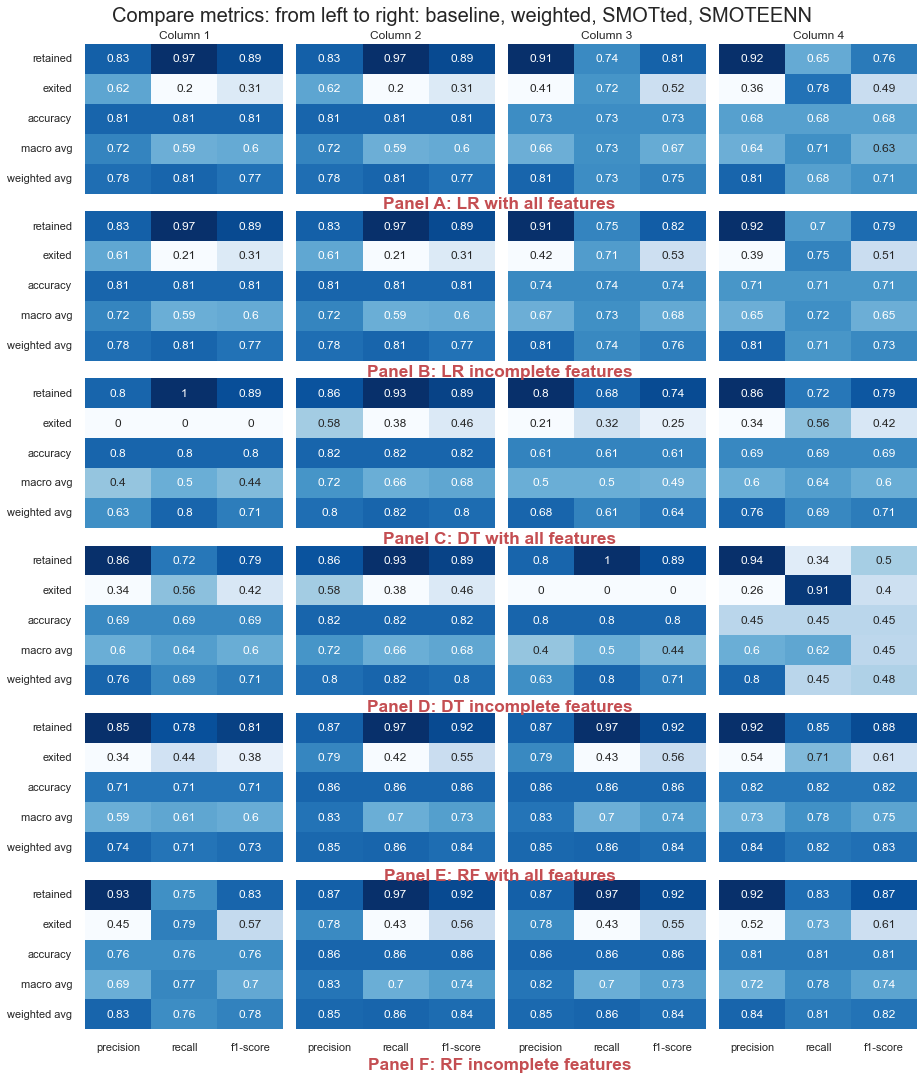

In [95]:
sns.set()
#fig,axes = plt.subplots(6, 4, figsize=(15, 25), sharey=True)


cols = ['Column {}'.format(col) for col in range(1, 5)]
rows = ['Panel {}'.format(row) for row in ['A', 'B', 'C', 'D', 'E', 'F']]

fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(13, 15), sharey=True, sharex=True)
fig.suptitle('Compare metrics: from left to right: baseline, weighted, SMOTted, SMOTEENN', fontsize=20)


for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for ax, row in zip(axes[:,-1], rows):
    ax.set_ylabel(row, rotation=90, size ='large', color="r", fontweight='bold' )
    ax.yaxis.set_label_position("right")

    
for i in range(24):
    im = sns.heatmap(pd.DataFrame(clf_rep_lst[i]).iloc[:-1, :].T, 
              cmap = "Blues", annot=True, cbar = False, ax = axes.flat[i])
#fig.colorbar(im, ax=axes, location='right')
plt.subplots_adjust(hspace=5)

# Add text in figure coordinates
plt.figtext(0.54, .797, 'Panel A: LR with all features', ha='center', va='center', color = 'r', size ='x-large' ,fontweight='bold')
plt.figtext(0.54, .642, 'Panel B: LR incomplete features', ha='center', va='center', color = 'r', size ='x-large' ,fontweight='bold')
plt.figtext(0.54, .487, 'Panel C: DT with all features', ha='center', va='center', color = 'r', size ='x-large' ,fontweight='bold')
plt.figtext(0.54, .332, 'Panel D: DT incomplete features', ha='center', va='center', color = 'r', size ='x-large' ,fontweight='bold')
plt.figtext(0.54, .175, 'Panel E: RF with all features', ha='center', va='center', color = 'r', size ='x-large' ,fontweight='bold')
plt.figtext(0.54, .0, 'Panel F: RF incomplete features', ha='center', va='center', color = 'r', size ='x-large' ,fontweight='bold')


plt.tight_layout()

#### Conclusion:
The F1 score for the exited minority class is best for the SMOTted model for the logistic regression. The F1 score for the exited minority class is best for the weighted decision trees.  the F1 score for all imbalance methods performed well for the random forest, but it was best for the SMOTEENN.  It is noteworthy that the F1 for the exited minority class in the basic random forest models of the reduced features performed better than weighted and SMOTted, but less SMOTEENN.  So the effect of a reduced feature classification is apparent only in the random forest panels.

### Compare eight best models
Random forest model number 17, 18, 19 20, 21, 22, 23  24,

#### Conclusion:
As shown in this  graph  above, the overall performance of our models of choice, i.e., the random forest with the highest precision  is the lowest in overall random forest.  So I will drop them and keep the best 4 random forest with the highest AUC overall.  There, I will choose based on class precision.

### Compare the best 4

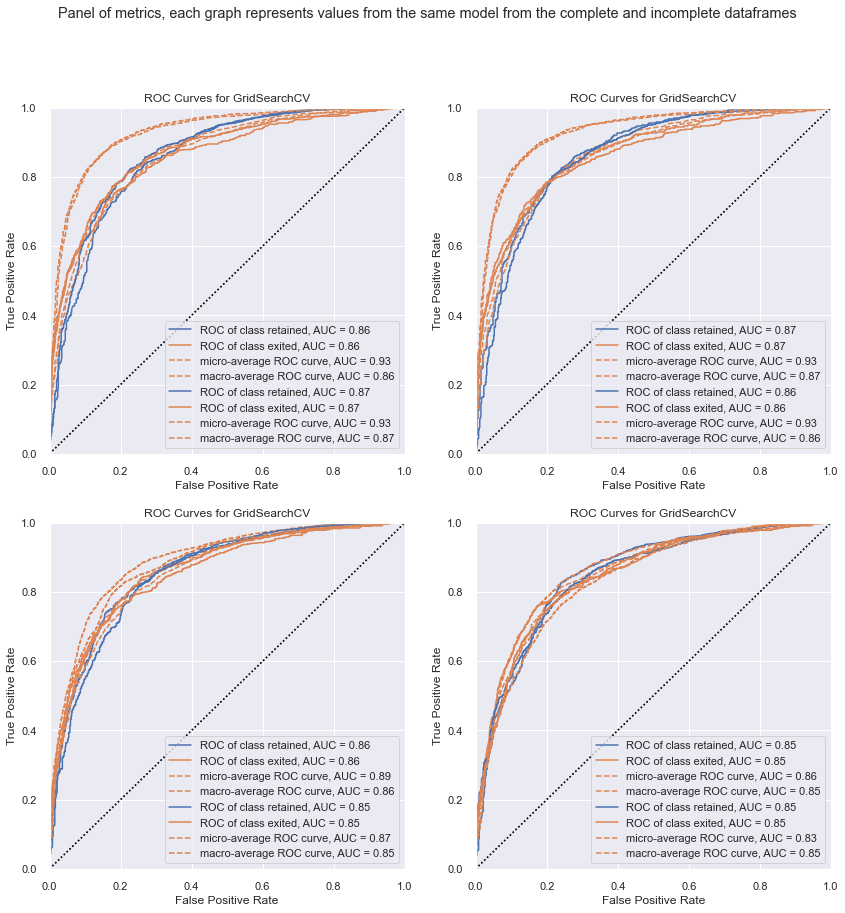

In [109]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(14, 14))
plt.suptitle("Panel of metrics, each graph represents values from the same model from the complete and incomplete dataframes")


visualizer = ROCAUC(rf_sm_from_joblib, classes=["retained", "exited"], ax=ax3)
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)
visualizer.finalize()

visualizer = ROCAUC(rf_sm_inc_from_joblib, classes=["retained", "exited"], ax=ax3)
visualizer.fit(X_train_inc, y_train_inc)        # Fit the training data to the visualizer
visualizer.score(X_test_inc, y_test_inc)
visualizer.finalize()

visualizer = ROCAUC(rf_sme_inc_from_joblib, classes=["retained", "exited"], ax=ax4)
visualizer.fit(X_train_inc, y_train_inc)        # Fit the training data to the visualizer
visualizer.score(X_test_inc, y_test_inc)
visualizer.finalize()
                                 
visualizer = ROCAUC(rf_sme_from_joblib, classes=["retained", "exited"], ax=ax4)
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)
visualizer.finalize() 

visualizer = ROCAUC(rf_inc_from_joblib, classes=["retained", "exited"], ax=ax1)
visualizer.fit(X_train_inc, y_train_inc)        # Fit the training data to the visualizer
visualizer.score(X_test_inc, y_test_inc)
visualizer.finalize() 

visualizer = ROCAUC(rf_from_joblib, classes=["retained", "exited"], ax=ax1)
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)
visualizer.finalize() 

visualizer = ROCAUC(rf_wt_from_joblib, classes=["retained", "exited"], ax=ax2)
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)
visualizer.finalize() 

visualizer = ROCAUC(rf_wt_inc_from_joblib, classes=["retained", "exited"], ax=ax2)
visualizer.fit(X_train_inc, y_train_inc)        # Fit the training data to the visualizer
visualizer.score(X_test_inc, y_test_inc)
visualizer.finalize() 



#### Conclusion:
Of these models, we want a solid orange line that represents the AUC of the exited minority class. We have two winners with .87 for the exited class.  They are the random forest upsamled using SMOTE and a mix of SMOTE and undersampling using SMOTEENN.

###  Last check

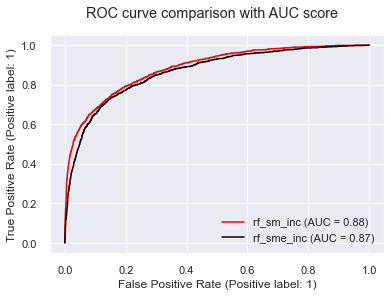

In [106]:
fig = plot_roc_curve(rf_sm_inc_from_joblib, X_train_inc, y_train_inc,  name = "rf_sm_inc" , color="red")
ig = plot_roc_curve(rf_sme_inc_from_joblib, X_train_inc, y_train_inc, name = "rf_sme_inc" ,color="black", ax = fig.ax_)


fig.figure_.suptitle("ROC curve comparison with AUC score")
plt.show() 

#### Conclusion:
It is clear that the red curve is our best curve.  It is also interesting that our best two curves also are generated from the incomplete dataframe without all the features.

## Sanity check with  dummy models

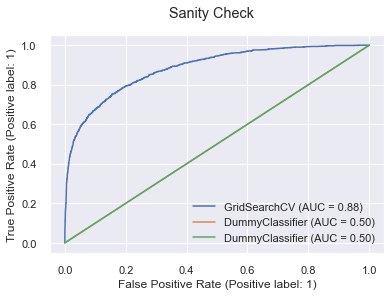

In [108]:
fig = plot_roc_curve(rf_sm_inc_from_joblib, X_train_inc, y_train_inc)
fig = plot_roc_curve(dummy_model1, X_train, y_train, ax = fig.ax_)
fig = plot_roc_curve(dummy_model2, X_train, y_train, ax = fig.ax_)
fig.figure_.suptitle("Sanity Check")
plt.show() 

### Conclusion:
We definitely improved on our dummy models.

# General substantive conclusion:

- We have used three different classifier classes for this project: logistic regression, decision tree and random forests.
- I ran a MNlogistic regression model and created a dataframe in which I dropped the variables without a p-value lower than 0.05.  This new dataframe is called inc
- Because the target variable is imbalanced, I used 4 models for each classifier: basic, weighted, upsamples using SMOTE and a combination of upsampling and downsampling using SMOTEENN.  I used the same method for both the dataframe with complete and incomplete features.
- I found that random forest were best at classifying the minority class of interest.
- Our best classifier is a random forest, ran on the incomplete dataframe using SMOTting.